In [2]:
from scipy import stats
import numpy as np
from pyvbmc import  VBMC
import pickle
from ddm_utils import prob_rt_mu, parse_sim_results, rtd_mu_small_t, prob_rt_generic, prob_rt_mu_posterior, rtd_mu
import matplotlib.pyplot as plt
from joblib import Parallel, delayed



In [10]:
prior_bounds = { 'a_low': 0.1, 'a_high': 5, 'v_low': 0.1, 'v_high': 5 }
with open('prior_bounds.pkl', 'wb') as f:
    pickle.dump(prior_bounds, f)


In [48]:
def log_prior(params):
    v,a = params
    with open('prior_bounds.pkl', 'rb') as f:
        prior_bounds = pickle.load(f)

    v_prior = stats.uniform(prior_bounds['v_low'], prior_bounds['v_high'])
    a_prior = stats.uniform(prior_bounds['a_low'], prior_bounds['a_high'])
    
    log_prior_v = v_prior.logpdf(v)
    log_prior_a = a_prior.logpdf(a)
    return log_prior_v + log_prior_a

def rtd_mu_small_t_parallel(t, mu, K_max=4):
    non_sum_term = 2 * np.cosh(mu) * np.exp(-(mu**2)*t/2) * (1/np.sqrt(2*np.pi*(t**3)))
    k_vals = np.linspace(0, K_max, K_max + 1)
    sum_neg_1_term = (-1)**k_vals
    sum_two_k_term = (2*k_vals) + 1
    sum_exp_term = np.exp(-((2*k_vals + 1)**2)/(2*t))
    sum_term = np.sum(sum_neg_1_term*sum_two_k_term*sum_exp_term)
    return non_sum_term*sum_term

def log_like(params):
    v,a = params
    mu = v*(a/2)
    with open('sample_rt.pkl', 'rb') as f:
        t_arr = pickle.load(f)
    probs = Parallel(n_jobs=-1)(delayed(rtd_mu_small_t_parallel)(t, mu) for t in t_arr)
    # loglike_norm = np.sum(np.log(probs))*(1/len(t_arr))
    loglike_norm = np.sum(np.log(probs))
    print(f"v={v},a={a},loglike={loglike_norm}")
    return loglike_norm

def log_joint(params):
    return log_like(params) + log_prior(params)




#  # Is log_like working?

In [49]:
# read from all_sim_pkl 
with open('all_sim_results.pkl', 'rb') as f:
    all_sim_results = pickle.load(f)

a = 2; v = 2;
keyname = f"a={str(a)},v={str(v)}"
choices, RTs = parse_sim_results(all_sim_results[keyname])
with open('sample_rt.pkl', 'wb') as f:
        pickle.dump(RTs, f)

# testing for sum log prob for diff a,v pairs
a = 1; v = 1; print(log_like([a,v]))
a = 2; v = 2; print(log_like([a,v]))
a = 3; v = 3; print(log_like([a,v]))

v=1,a=1,loglike=-16114.549935717416
-16114.549935717416
v=2,a=2,loglike=-1331.6623782380702
-1331.6623782380702
v=3,a=3,loglike=-74232.9280021424
-74232.9280021424


In [50]:
# read from all_sim_pkl 
with open('all_sim_results.pkl', 'rb') as f:
    all_sim_results = pickle.load(f)

a = 2; v = 2;
keyname = f"a={str(a)},v={str(v)}"
choices, RTs = parse_sim_results(all_sim_results[keyname])
with open('sample_rt.pkl', 'wb') as f:
        pickle.dump(RTs, f)


In [51]:
lower_bounds = np.array([0.1, 0.1]) 
upper_bounds = np.array([3, 3])
plausible_lower_bounds = np.array([0.5, 0.5])
plausible_upper_bounds = np.array([2.9,2.9])


x0 = np.array([1.2,1.5])

In [52]:
options = {'display': 'off'}
vbmc = VBMC(log_joint, x0, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds, options=options)
vp, results = vbmc.optimize()


Reshaping x0 to row vector.
Reshaping lower bounds to (1, 2).
Reshaping upper bounds to (1, 2).
Reshaping plausible lower bounds to (1, 2).
Reshaping plausible upper bounds to (1, 2).
Casting upper bounds to floating point.
v=1.2,a=1.5,loglike=-10917.674771724849
v=2.1593502454221007,a=1.9575230697026673,loglike=-1499.646078812803
v=0.7857734134208573,a=2.4571761837719817,loglike=-10004.014450353088
v=1.9139305752025337,a=1.4281279394091688,loglike=-4907.86995921963
v=2.6722966454542036,a=2.4729298939456243,loglike=-20826.028687894453
v=0.9546291472726781,a=0.8262863911456448,loglike=-17183.320634376894
v=1.8651414980043524,a=2.2954312038039855,loglike=-1580.430571587869
v=2.5343639608696256,a=2.7482729670122437,loglike=-26603.09330201437
v=1.4952041913297178,a=2.0201633615219,loglike=-3503.8634599413876
v=1.9590747572465645,a=2.754780080821006,loglike=-6873.47581854312
v=1.9263459671290788,a=2.083894889507916,loglike=-1334.272843378662
v=1.9457022081423916,a=2.0621336835413926,loglike

# Ground Truth 

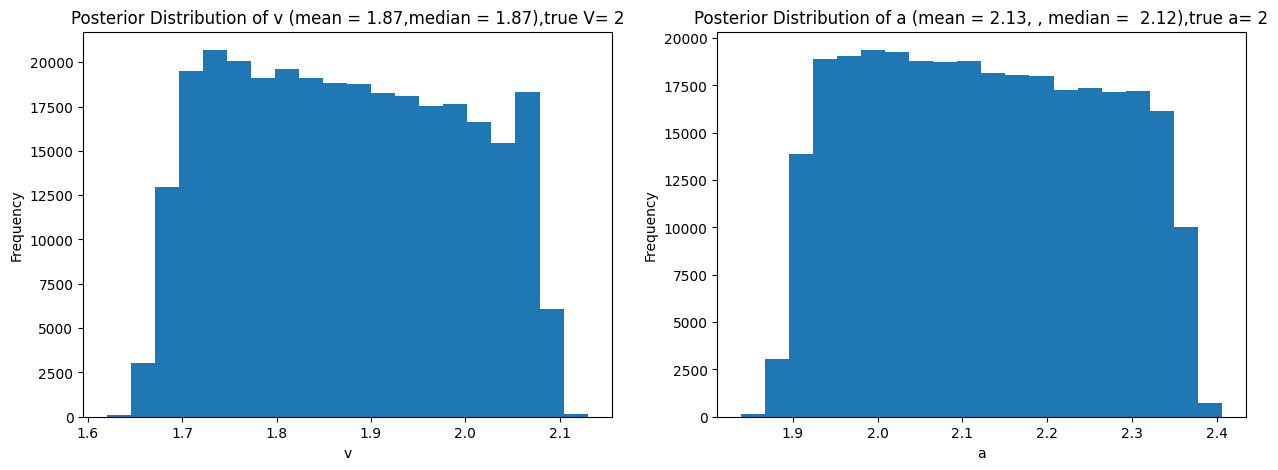

In [53]:
v_a, _ = vp.sample(int(3e5))
v_post = v_a[:,0]
a_post = v_a[:,1]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(v_post, bins=20)
plt.title(f'Posterior Distribution of v (mean = {np.mean(v_post):.2f},median = {np.median(v_post) :.2f}),true V= {v}')
plt.xlabel('v')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(a_post, bins=20)
plt.title(f'Posterior Distribution of a (mean = {np.mean(a_post):.2f}, , median = {np.median(a_post): .2f}),true a= {a}')
plt.xlabel('a')
plt.ylabel('Frequency');


# Scatter plot: high a, low v

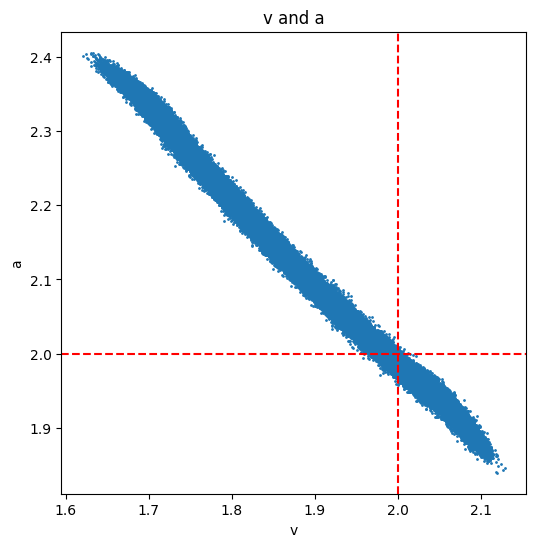

In [54]:
plt.figure(figsize=(6, 6))
plt.scatter(v_post, a_post, s=1)
plt.axvline(x=2, color='r', linestyle='--')
plt.axhline(y=2, color='r', linestyle='--')

plt.xlabel('v')
plt.ylabel('a')
plt.title('v and a')
plt.show()

# Dynesty?

In [55]:
from dynesty import NestedSampler
      
from dynesty import plotting as dyplot

In [56]:
def transform_random_number(u, a, b):
    return (b-a)*u + a 


In [58]:
def prior_transform(u):
    # u ~ uniform [0,1]
    priors = np.array(u)

    # a: 0 to 20
    priors[0] =  transform_random_number(u[0], 0.1, 3)


    # c: -5 to 5
    priors[1] = transform_random_number(u[1], 0.1, 3)

    return priors

In [59]:
ndim = 2
# sampler = NestedSampler(log_likelihood, prior_transform, ndim)
sampler = NestedSampler(log_like, prior_transform, ndim, nlive = 1000)

v=2.2470197332653927,a=1.3106479370897939,loglike=-3844.291918256285
v=1.4370163310387525,a=2.272714843761055,loglike=-2553.137158717606
v=2.987802352667331,a=0.2482796488769079,loglike=-17394.098841355833
v=1.4074961997331878,a=0.36444101320555666,loglike=-18260.191044737956
v=0.6327029954273592,a=2.520492563066182,loglike=-12347.005738352378
v=0.5624166831565673,a=2.8675952053696014,loglike=-12222.284905217912
v=0.8542245981345566,a=0.7979680138171882,loglike=-17648.26701548261
v=0.22971954121645358,a=2.1026007335246106,loglike=-18352.42651443732
v=0.23420794999775904,a=2.0791595364847386,loglike=-18340.559431881575
v=0.3282045196557385,a=2.777788835867421,loglike=-16584.318053420902
v=0.41445616635365456,a=0.20945732991855515,loglike=-19065.261222484434
v=1.694389584173004,a=0.46857796964711806,loglike=-17159.55213276202
v=0.26077331655641456,a=0.20734484158074043,loglike=-19080.097578029396
v=0.8955699640858819,a=1.6581193184286784,loglike=-13097.32540081217
v=0.9231694141020002,a=

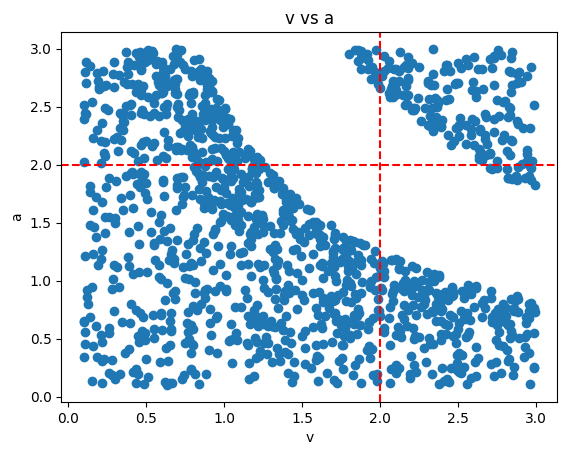

In [76]:
plt.scatter(sampler.results.samples[:,0], sampler.results.samples[:,1])
plt.axvline(x=2, color='r', linestyle='--')
plt.axhline(y=2, color='r', linestyle='--')
plt.xlabel('v'); plt.ylabel('a');plt.title('v vs a');

In [74]:
results = sampler.results
results.samples[:,0].mean(), results.samples[:,1].mean() # 2,2


(1.46819486118133, 1.5072420825250141)